# Random Coefficients Logit Tutorial with the Automobile Data

In [2]:
import pyblp
import numpy as np
import pandas as pd 

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'0.12.0'

In this tutorial, we'll use data from [Berry, Levinsohn, and Pakes (1995)](https://pyblp.readthedocs.io/en/stable/references.html#berry-levinsohn-and-pakes-1995) to solve the paper's automobile problem.


## Application of Random Coefficients Logit with the Automobile Data

This tutorial is similar to the [fake cereal tutorial](nevo.ipynb), but exhibits some other features of pyblp:

- Incorporating a supply side into demand estimation.
- Allowing for simple price-income demographic effects.
- Calculating clustered standard errors.


### Loading the Data

We'll use [pandas](https://pandas.pydata.org/) to load two sets of data:

1. `product_data`, which contains prices, shares, and other product characteristics.
2. `agent_data`, which contains draws from the distribution of heterogeneity.

In [3]:
product_data = pd.read_csv(pyblp.data.BLP_PRODUCTS_LOCATION)
product_data.head()

,market_ids,clustering_ids,car_ids,firm_ids,region,shares,prices,hpwt,air,mpd,...,supply_instruments2,supply_instruments3,supply_instruments4,supply_instruments5,supply_instruments6,supply_instruments7,supply_instruments8,supply_instruments9,supply_instruments10,supply_instruments11
0,1971,AMGREM71,129,15,US,0.001051,4.935802,0.528997,0,1.888146,...,0.0,1.705933,1.595656,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.888146
1,1971,AMHORN71,130,15,US,0.000670,5.516049,0.494324,0,1.935989,...,0.0,1.680910,1.490295,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.935989
2,1971,AMJAVL71,132,15,US,0.000341,7.108642,0.467613,0,1.716799,...,0.0,1.801067,1.357703,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.716799
3,1971,AMMATA71,134,15,US,0.000522,6.839506,0.426540,0,1.687871,...,0.0,1.818061,1.261347,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.687871
4,1971,AMAMBS71,136,15,US,0.000442,8.928395,0.452489,0,1.504286,...,0.0,1.933210,1.237365,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.504286


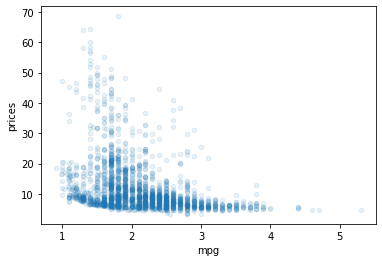

In [21]:
product_data.plot.scatter(x='mpg', y='prices', alpha=0.1);

The `product_data` contains market IDs, product IDs, firm IDs, shares, prices, a number of product characteristics, and instruments. The product IDs are called `clustering_ids` because they will be used to compute clustered standard errors. For more information about the instruments and the example data as a whole, refer to the [`data`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.data.html#module-pyblp.data) module.

The `agent_data` contains market IDs, integration weights $w_{it}$, integration nodes $\nu_{it}$, and demographics $d_{it}$. Here we use the $I_t = 200$ importance sampling weights and nodes from the original paper.

In non-example problems, it is usually a better idea to use many more draws, or a more sophisticated [`Integration`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Integration.html#pyblp.Integration) configuration such as sparse grid quadrature.

In [4]:
agent_data = pd.read_csv(pyblp.data.BLP_AGENTS_LOCATION)
agent_data.head()

,market_ids,weights,nodes0,nodes1,nodes2,nodes3,nodes4,income
0,1971,0.000543,1.192188,0.478777,0.980830,-0.824410,2.473301,109.560369
1,1971,0.000723,1.497074,-2.026204,-1.741316,1.412568,-0.747468,45.457314
2,1971,0.000544,1.438081,0.813280,-1.749974,-1.203509,0.049558,127.146548
3,1971,0.000701,1.768655,-0.177453,0.286602,0.391517,0.683669,22.604045
4,1971,0.000549,0.849970,-0.135337,0.735920,1.036247,-1.143436,170.226032


### Setting up the Problem

Unlike the fake cereal problem, we won't absorb any fixed effects in the automobile problem, so the linear part of demand $X_1$ has more components. We also need to specify a formula for the random coefficients $X_2$, including a random coefficient on the constant, which captures correlation among all inside goods.

The primary new addition to the model relative to the fake cereal problem is that we add a supply side formula for product characteristics that contribute to marginal costs, $X_3$. The [patsy](https://patsy.readthedocs.io/en/stable/)-style formulas support functions of regressors such as the `log` function used below.

We stack the three product formulations in order: $X_1$, $X_2$, and $X_3$.

In [5]:
product_formulations = (
   pyblp.Formulation('1 + hpwt + air + mpd + space'),
   pyblp.Formulation('1 + prices + hpwt + air + mpd + space'),
   pyblp.Formulation('1 + log(hpwt) + air + log(mpg) + log(space) + trend')
)
product_formulations

(1 + hpwt + air + mpd + space,
 1 + prices + hpwt + air + mpd + space,
 1 + log(hpwt) + air + log(mpg) + log(space) + trend)

The original specification for the automobile problem includes the term $\log(y_i - p_j)$, in which $y$ is income and $p$ are prices. Instead of including this term, which gives rise to a host of numerical problems, we'll follow [Berry, Levinsohn, and Pakes (1999)](https://pyblp.readthedocs.io/en/stable/references.html#berry-levinsohn-and-pakes-1999) and use its first-order linear approximation, $p_j / y_i$. 

The agent formulation for demographics, $d$, includes a column of $1 / y_i$ values, which we'll interact with $p_j$. To do this, we will treat draws of $y_i$ as demographic variables.

In [7]:
agent_formulation = pyblp.Formulation('0 + I(1 / income)')
agent_formulation

I(1 / income)

As in the cereal example, the [`Problem`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.html#pyblp.Problem) can be constructed by combining the `product_formulations`, `product_data`, `agent_formulation`, and `agent_data`. We'll also choose the functional form of marginal costs $c_{jt}$. A linear marginal cost specification is the default setting, so we'll need to use the `costs_type` argument of [`Problem`](https://pyblp.readthedocs.io/en/stable/_api/pyblp.Problem.html#pyblp.Problem) to employ the log-linear specification used by [Berry, Levinsohn, and Pakes (1995)](https://pyblp.readthedocs.io/en/stable/references.html#berry-levinsohn-and-pakes-1995).

In [8]:
problem = pyblp.Problem(product_formulations, product_data, agent_formulation, agent_data, costs_type='log')
problem

Dimensions:
 T    N     F    I     K1    K2    K3    D    MD    MS 
---  ----  ---  ----  ----  ----  ----  ---  ----  ----
20   2217  26   4000   5     6     6     1    13    18 

Formulations:
       Column Indices:            0          1       2       3          4         5  
-----------------------------  --------  ---------  ----  --------  ----------  -----
 X1: Linear Characteristics       1        hpwt     air     mpd       space          
X2: Nonlinear Characteristics     1       prices    hpwt    air        mpd      space
X3: Log Cost Characteristics      1      log(hpwt)  air   log(mpg)  log(space)  trend
       d: Demographics         1/income                                              

The problem outputs a table of dimensions:

- $T$ denotes the number of markets.
- $N$ is the length of the dataset (the number of products across all markets).
- $F$ denotes the number of firms.
- $I = \sum_t I_t$ is the total number of agents across all markets (200 draws per market times 20 markets).
- $K_1$ is the number of linear demand characteristics.
- $K_2$ is the number of nonlinear demand characteristics.
- $K_3$ is the number of linear supply characteristics.
- $D$ is the number of demographic variables.
- $M_D$ is the number of demand instruments, including exogenous regressors.
- $M_S$ is the number of supply instruments, including exogenous regressors.

The formulations table describes all four formulas for demand-side linear characteristics, demand-side nonlinear characteristics, supply-side characteristics, and demographics.

### Solving the Problem

The only remaining decisions are:

- Choosing $\Sigma$ and $\Pi$ starting values, $\Sigma_0$ and $\Pi_0$.
- Potentially choosing bounds for $\Sigma$ and $\Pi$.

The decisions we will use are:

- Use published estimates as our starting values in $\Sigma_0$.
- Interact the inverse of income, $1 / y_i$, only with prices, and use the published estimate on $\log(y_i - p_j)$ as our starting value for $\alpha$ in $\Pi_0$.
- Bound $\Sigma_0$ to be positive since it is a diagonal matrix where the diagonal consists of standard deviations.

When using a routine that supports bounds, it's usually a good idea to set your own more bounds so that the routine doesn't try out large parameter values that create numerical issues.

In [9]:
initial_sigma = np.diag([3.612, 0, 4.628, 1.818, 1.050, 2.056])
initial_pi = np.c_[[0, -43.501, 0, 0, 0, 0]]

Note that there are only 5 nonzeros on the diagonal of $\Sigma$, which means that we only need 5 columns of integration nodes to integrate over these 5 dimensions of unobserved heterogeneity. Indeed, `agent_data` contains exactly 5 columns of nodes. If we were to ignore the $\log(y_i - p_j)$ term (by not configuring $\Pi$) and include a term on prices in $\Sigma$ instead, we would have needed 6 columns of integration nodes in our `agent_data`.

A downside of the log-linear marginal costs specification is that nonpositive estimated marginal costs can create problems for the optimization routine when computing $\log c(\hat{\theta})$. We'll use the `costs_bounds` argument to bound marginal costs from below by a small number. 

Finally, as in the original paper, we'll use `W_type` and `se_type` to cluster by product IDs, which were specified as `clustering_ids` in `product_data`, and set `initial_update=True` to update the initial GMM weighting matrix and the mean utility at the starting parameter values.

In [10]:
results = problem.solve(
    initial_sigma,
    initial_pi,
    costs_bounds=(0.001, None),
    W_type='clustered',
    se_type='clustered',
    initial_update=True,
)
results

Problem Results Summary:
GMM   Objective    Projected    Reduced Hessian  Reduced Hessian  Clipped  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares    Costs   Condition Number  Condition Number 
----  ---------  -------------  ---------------  ---------------  -------  -------  ----------------  -----------------
 2    +5.0E+02     +3.1E-09        +4.9E-01         +5.1E+02         0        0         +4.2E+09          +3.8E+08     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:04:27       No           58           146         40949       125581   

Nonlinear Coefficient Estimates (Robust SEs Adjusted for 999 Clusters in Parentheses):
Sigma:      1        prices      hpwt        air         mpd        space     |

There are some discrepancies between our results and the original paper, but results are similar.